In [1]:
# --- Standard Library ---
import itertools                         # Hyperparameter grid searching (windows, lags, etc.)
from datetime import datetime, timedelta # Time window management for sliding/walk-forward windows

# --- Data Handling & Math ---
import numpy as np                       # Vectorized operations on returns and signals
import pandas as pd                      # Core TimeSeries container (OHLCV data)
import yfinance as yf                    # Quick ingestion of historical market data

# --- Statistics & Stationarity (The "Bayesian" Foundation) ---
from scipy.stats import shapiro, jarque_bera          # Normality tests for return distributions
from statsmodels.tsa.stattools import adfuller        # Augmented Dickey-Fuller (ADF) for unit root/stationarity
from statsmodels.stats.diagnostic import het_arch     # Test for ARCH effects (volatility clustering)
from statsmodels.stats.diagnostic import acorr_ljungbox # Test for remaining autocorrelation in residuals

# --- Time Series Econometrics ---
import arch                              # GARCH models for volatility forecasting/regime detection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Identifying significant lags for retraining

# --- Visualization ---
import matplotlib.pyplot as plt          # Plotting equity curves, drawdowns, and price/signal overlays

## Data Ingestion & Persistence
> This section handles the data acquisition for the **CAC 40 (^FCHI)**. 
> To ensure reproducibility and speed, we implement a **local caching mechanism**:
> 1. We check if a local `.parquet` file exists in the `data/` directory.
> 2. If it exists, we load it to avoid unnecessary API calls.
> 3. If not, we fetch the data from Yahoo Finance and serialize it locally for future use.
>
> 

In [2]:
import os
from pathlib import Path

# Configuration
ticker = '^FCHI'
start_date, end_date = ('2000-01-01', '2025-12-31')
cache_dir = Path("../data")
cache_file = cache_dir / f"{ticker.replace('^', '')}_{start_date}_{end_date}.parquet"

# Ensure the data directory exists
cache_dir.mkdir(exist_ok=True)

if cache_file.exists():
    # Load from local cache
    print(f"--- Loading data from cache: {cache_file} ---")
    data = pd.read_parquet(cache_file)
else:
    # Fetch from API
    print(f"--- Fetching data for {ticker} from Yahoo Finance ---")
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Simple validation: ensure we have data before saving
    if not data.empty:
        # Saving to Parquet (efficient storage for time series)
        data.to_parquet(cache_file)
        print(f"--- Data saved to: {cache_file} ---")
    else:
        print("⚠️ Warning: No data was retrieved. Check ticker or date range.")

# Preview the data
data.head()

--- Loading data from cache: ../data/FCHI_2000-01-01_2025-12-31.parquet ---


Price,Close,High,Low,Open,Volume
Ticker,^FCHI,^FCHI,^FCHI,^FCHI,^FCHI
Date,,,,,
2000-01-03,5917.370117,6102.120117,5901.770020,6024.379883,0
2000-01-04,5672.020020,5925.069824,5657.200195,5922.229980,0
2000-01-05,5479.700195,5589.500000,5461.589844,5521.830078,0
2000-01-06,5450.109863,5530.259766,5388.850098,5485.930176,0
2000-01-07,5539.609863,5561.689941,5423.879883,5423.879883,0


In [3]:
# Create a local copy to avoid modifying the original 'data' object
df_flat = data.copy()

# Collapse MultiIndex levels: (e.g., 'Close', '^FCHI') becomes just 'Close'
# This simplifies indexing for single-ticker research
df_flat.columns = df_flat.columns.get_level_values(0)

try:
    # Prioritize Adjusted Close to account for dividends/splits
    cac40 = df_flat['Adj Close']
except KeyError:
    # Fallback to Close if Adjusted Close is not provided by the API version
    cac40 = df_flat['Close']

# Display the first few rows to verify the time series
cac40.head()

Date
2000-01-03    5917.370117
2000-01-04    5672.020020
2000-01-05    5479.700195
2000-01-06    5450.109863
2000-01-07    5539.609863
Name: Close, dtype: float64

### Markdown Cell: Exploratory Data Analysis - Visual Inspection

> Before applying statistical tests, we perform a **Visual Inspection** of the time series. This step is crucial to identify:
> 1. **Trend**: Does the series move around a constant mean (stationary) or does it exhibit a long-term direction (non-stationary)?
> 2. **Seasonality**: Are there recurring patterns at fixed intervals?
> 3. **Variance**: Does the fluctuation amplitude change over time (**Heteroskedasticity**)?
> 4. **Structural Breaks**: Major market shocks that might require a model reset.
> 
> 

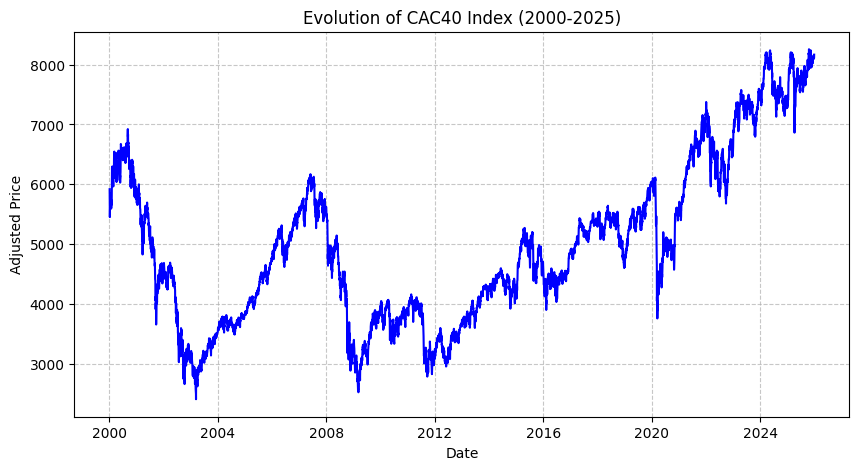

In [4]:
# Initialize a high-resolution plot for visual inspection
plt.figure(figsize=(10, 5))

# Plot the index price over time to detect trends and volatility clusters
plt.plot(cac40.index, cac40, color='blue', linewidth=1.5)

# Add descriptive metadata for the plot
plt.title('Evolution of CAC40 Index (2000-2025)')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')

# Enable grid for better estimation of price levels and time periods
plt.grid(True, linestyle='--', alpha=0.7)

# Render the plot
plt.show()

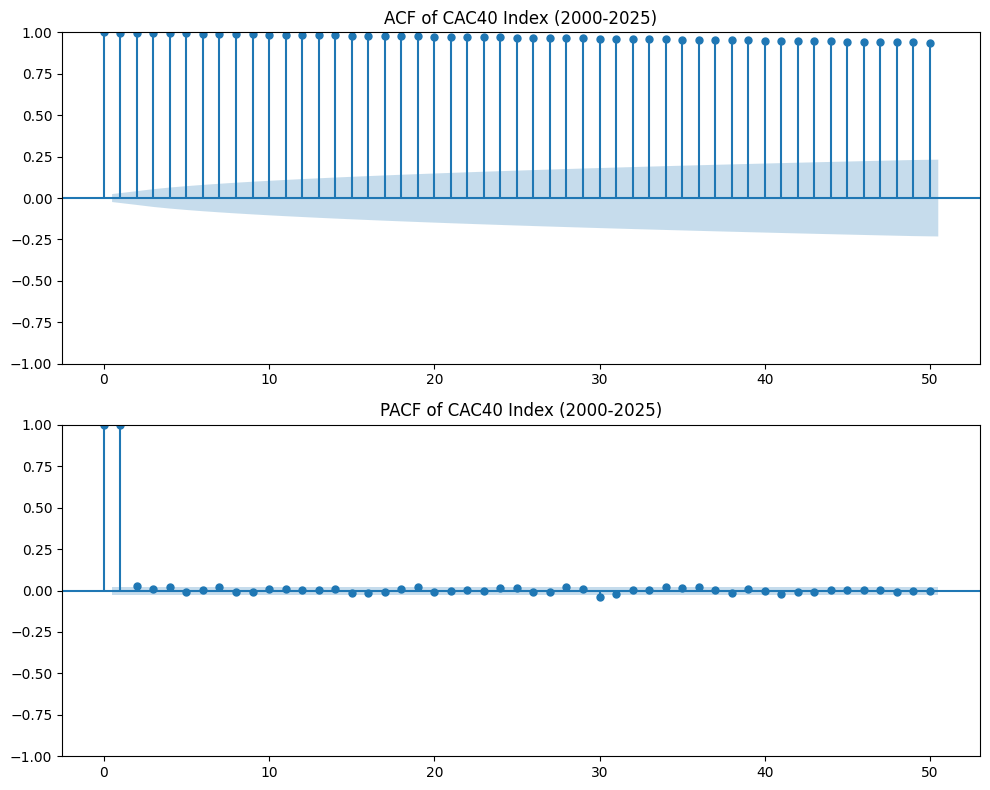

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(cac40, lags=50, ax=ax1)
ax1.set_title('ACF of CAC40 Index (2000-2025)')
plot_pacf(cac40, lags=50, ax=ax2)
ax2.set_title('PACF of CAC40 Index (2000-2025)')
plt.tight_layout()
plt.show()